Loading data
Entire data shape: (811457, 6)
Labeled data shape: (172950, 6)
Class list: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
Training data shape: (138359, 6)
Test data shape: (34591, 6)
Supervised - Training data shape: (900, 6)
Supervised - Test data shape: (430, 6)
Semi-supervised - Labeled training data shape: (900, 6)
Semi-supervised - Unlabeled training data shape: (10000, 6)
sup_train_images shape: (900, 26, 26, 3)
sup_test_images shape: (430, 26, 26, 3)
semi_sup_labeled_images shape: (900, 26, 26, 3)
semi_sup_unlabeled_images shape: (10000, 26, 26, 3)
Starting Autoencoder training
Autoencoder Epoch [1/15], Loss: 0.0710
Autoencoder Epoch [2/15], Loss: 0.0448
Autoencoder Epoch [3/15], Loss: 0.0412
Autoencoder Epoch [4/15], Loss: 0.0391
Autoencoder Epoch [5/15], Loss: 0.0374
Autoencoder Epoch [6/15], Loss: 0.0360
Autoencoder Epoch [7/15], Loss: 0.0349
Autoencoder Epoch [8/15], Loss: 0.0340
Autoencoder Epoch [9/15], Loss: 0.03

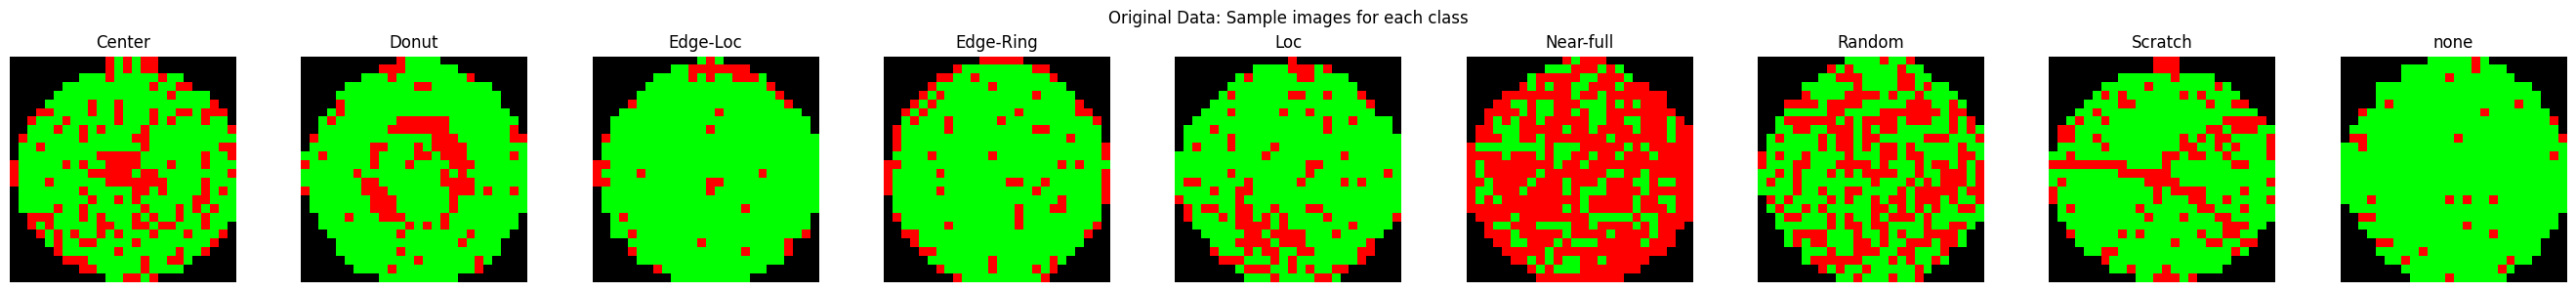


[Unlabeled Data] Displaying 2 samples


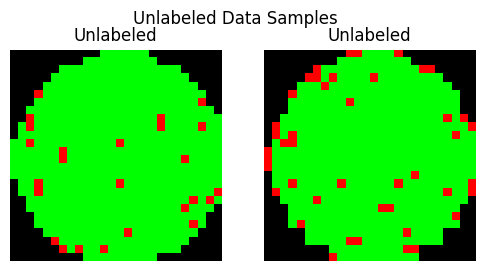


[Unlabeled Augmentation Comparison] Original vs Weak vs Strong


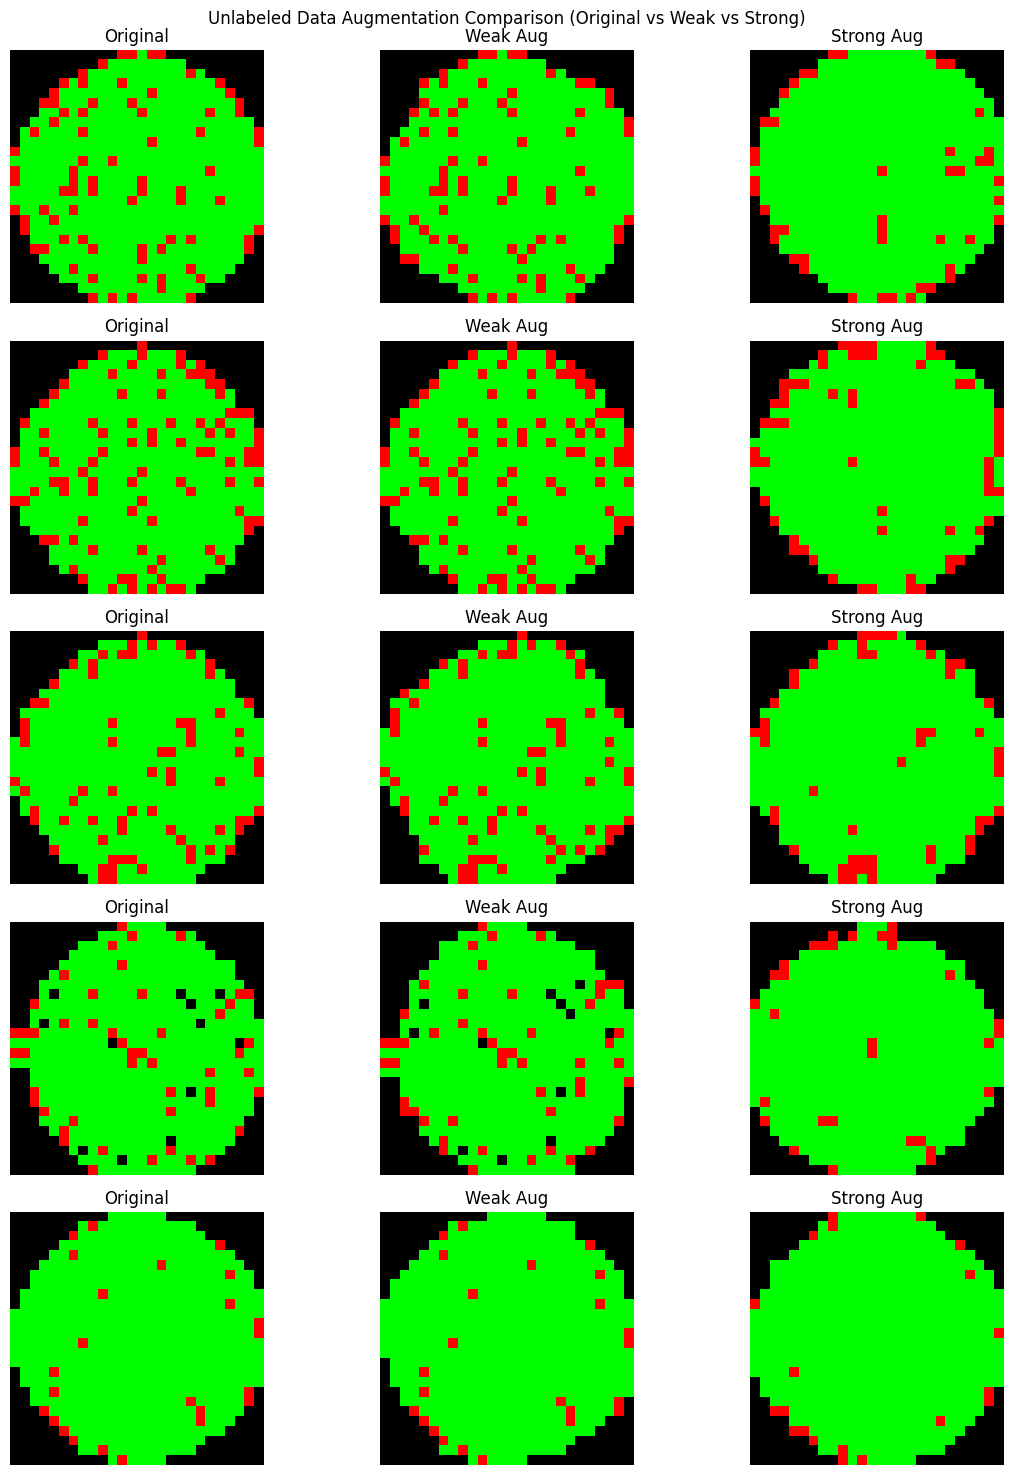


[Augmented Data] Augmented sample images for each class (2 each)


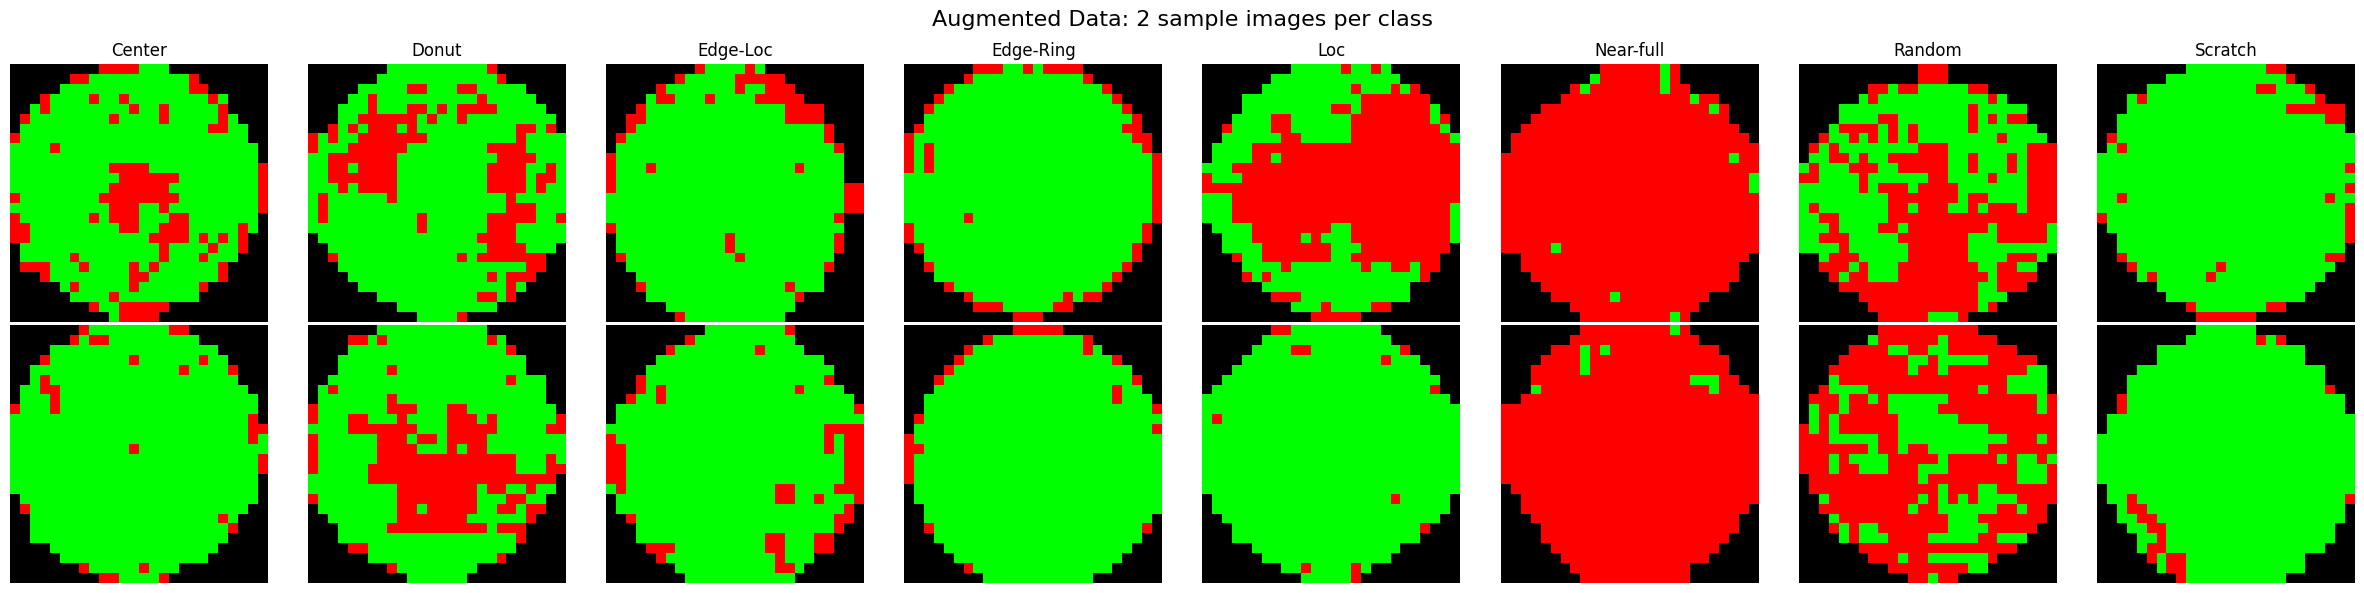


[Original vs Augmented] Comparison per class (supervised)


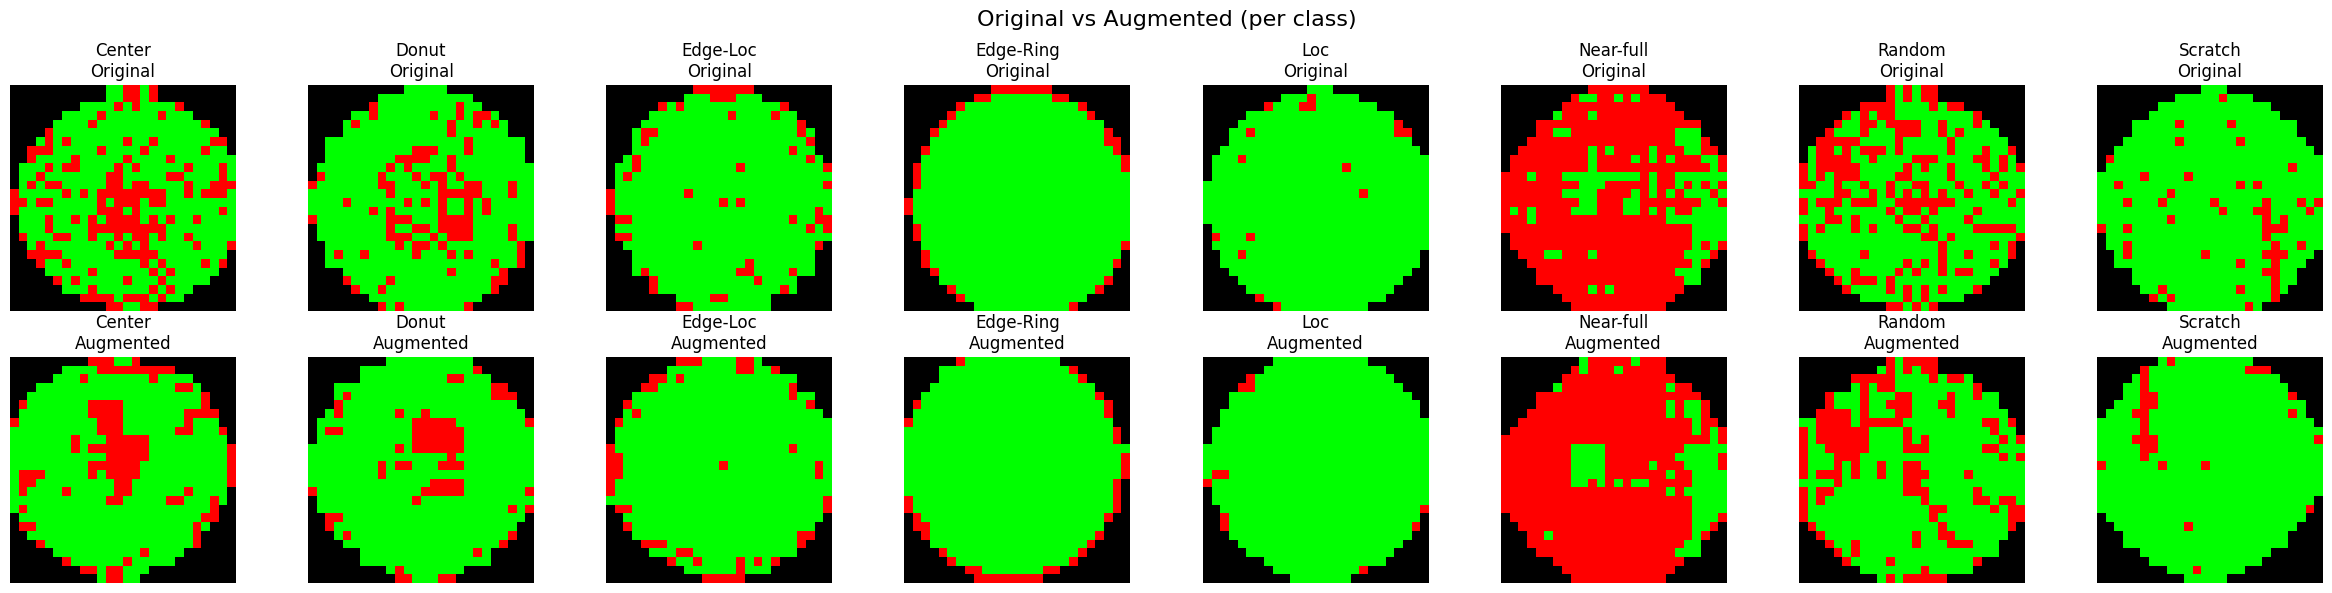


[Autoencoder Augmentation Comparison] per class (supervised)


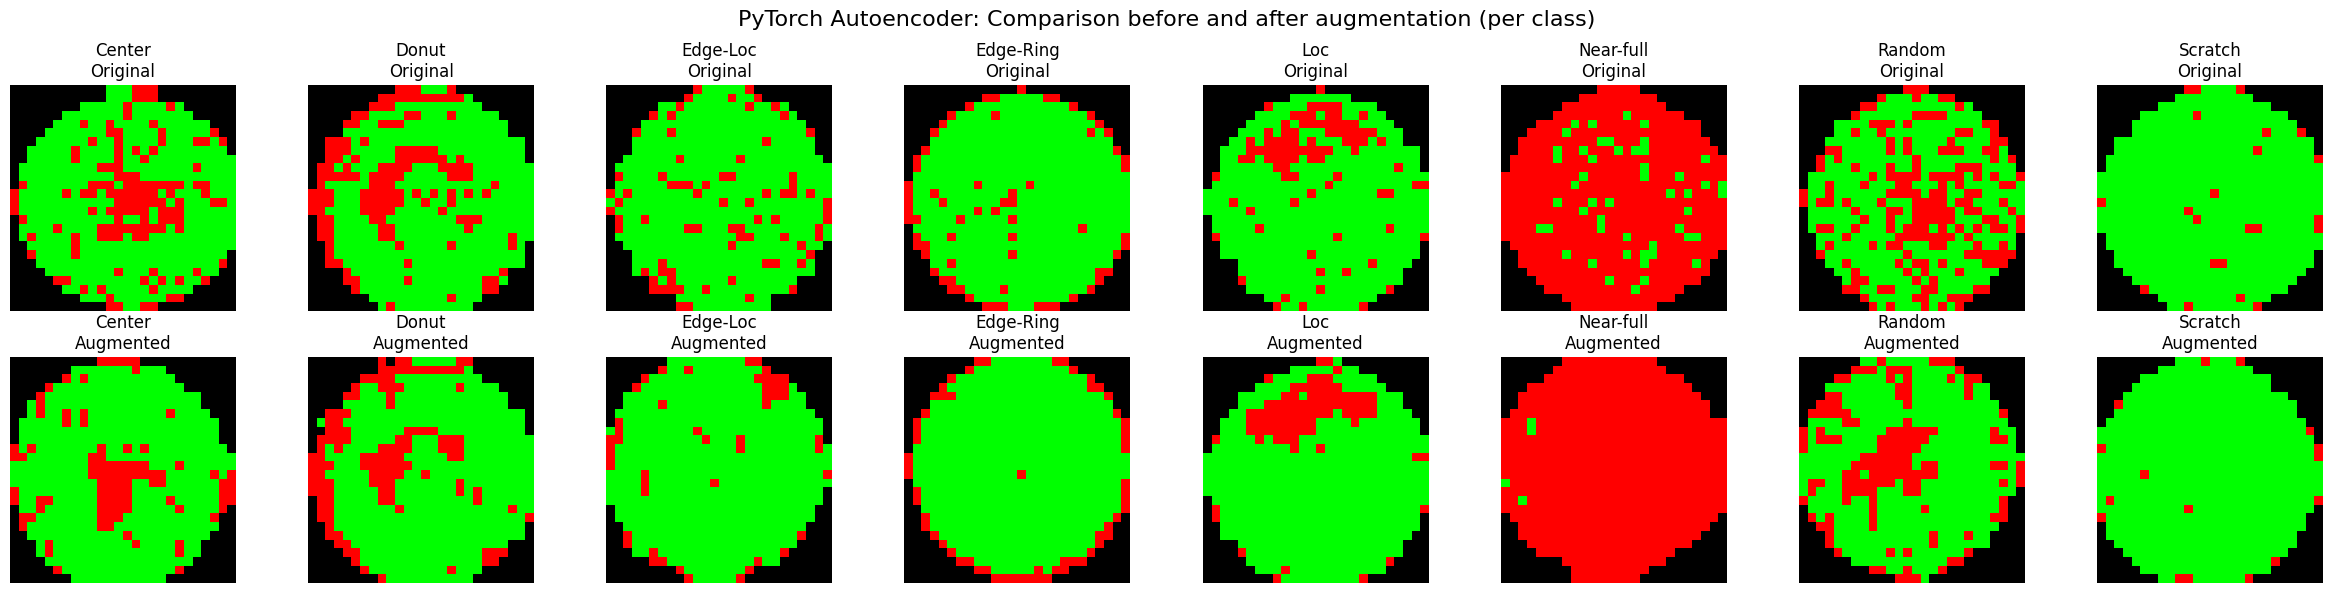


=== Supervised Experiment ===
[Supervised] Epoch 1 Loss: 1.6961
[Supervised] Epoch 2 Loss: 1.2003
[Supervised] Epoch 3 Loss: 1.0042
[Supervised] Epoch 4 Loss: 0.8648
[Supervised] Epoch 5 Loss: 0.8002
[Supervised] Epoch 6 Loss: 0.7497
[Supervised] Epoch 7 Loss: 0.6323
[Supervised] Epoch 8 Loss: 0.5708
[Supervised] Epoch 9 Loss: 0.5370
[Supervised] Epoch 10 Loss: 0.5201
[Supervised] Epoch 11 Loss: 0.4349
[Supervised] Epoch 12 Loss: 0.3930
[Supervised] Epoch 13 Loss: 0.3611
[Supervised] Epoch 14 Loss: 0.3633
[Supervised] Epoch 15 Loss: 0.3376
[Supervised] Epoch 16 Loss: 0.3414
[Supervised] Epoch 17 Loss: 0.2949
[Supervised] Epoch 18 Loss: 0.2791
[Supervised] Epoch 19 Loss: 0.2838
[Supervised] Epoch 20 Loss: 0.2651
[Supervised] Epoch 21 Loss: 0.2188
[Supervised] Epoch 22 Loss: 0.2009
[Supervised] Epoch 23 Loss: 0.1963
[Supervised] Epoch 24 Loss: 0.1813
[Supervised] Epoch 25 Loss: 0.1779
[Supervised] Epoch 26 Loss: 0.1876
[Supervised] Epoch 27 Loss: 0.1689
[Supervised] Epoch 28 Loss: 0.163

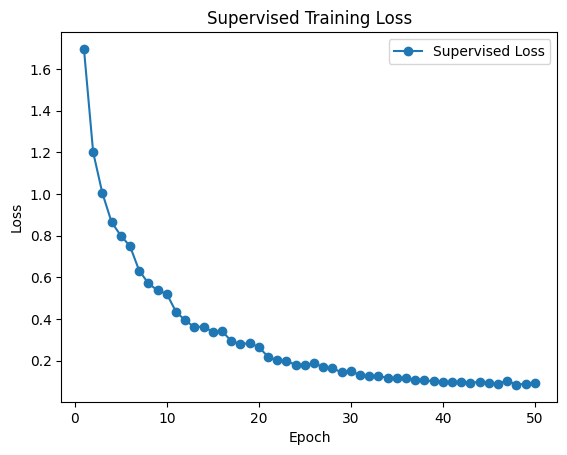

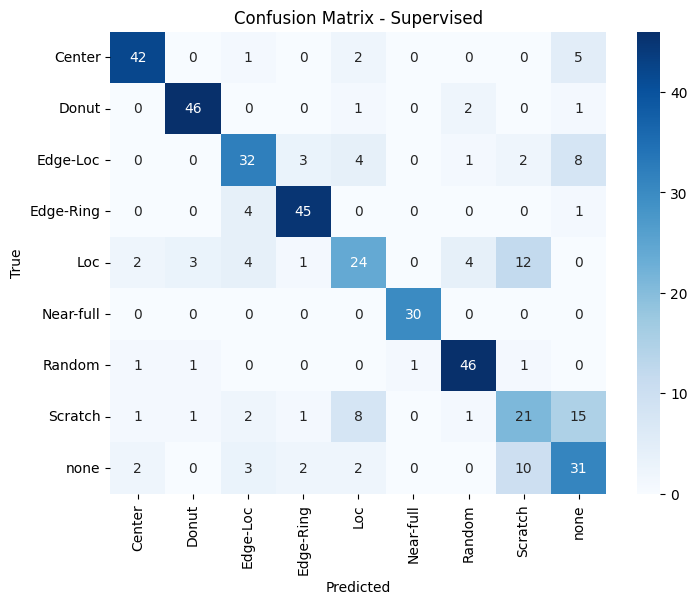


=== Semi-supervised Experiment ===
Epoch 1: Unlabeled usage ratio = 0.000 (1.0/6272)
[Semi-supervised] Epoch 1 Loss: 1.7806
Epoch 2: Unlabeled usage ratio = 0.001 (6.0/6272)
[Semi-supervised] Epoch 2 Loss: 1.2254
Epoch 3: Unlabeled usage ratio = 0.007 (43.0/6272)
[Semi-supervised] Epoch 3 Loss: 0.9874
Epoch 4: Unlabeled usage ratio = 0.022 (136.0/6272)
[Semi-supervised] Epoch 4 Loss: 0.8807
Epoch 5: Unlabeled usage ratio = 0.029 (180.0/6272)
[Semi-supervised] Epoch 5 Loss: 0.7934
Epoch 6: Unlabeled usage ratio = 0.037 (233.0/6272)
[Semi-supervised] Epoch 6 Loss: 0.8054
Epoch 7: Unlabeled usage ratio = 0.040 (250.0/6272)
[Semi-supervised] Epoch 7 Loss: 0.7210
Epoch 8: Unlabeled usage ratio = 0.052 (329.0/6272)
[Semi-supervised] Epoch 8 Loss: 0.6458
Epoch 9: Unlabeled usage ratio = 0.053 (335.0/6272)
[Semi-supervised] Epoch 9 Loss: 0.6199
Epoch 10: Unlabeled usage ratio = 0.053 (331.0/6272)
[Semi-supervised] Epoch 10 Loss: 0.5711
Epoch 11: Unlabeled usage ratio = 0.064 (404.0/6272)
[Sem

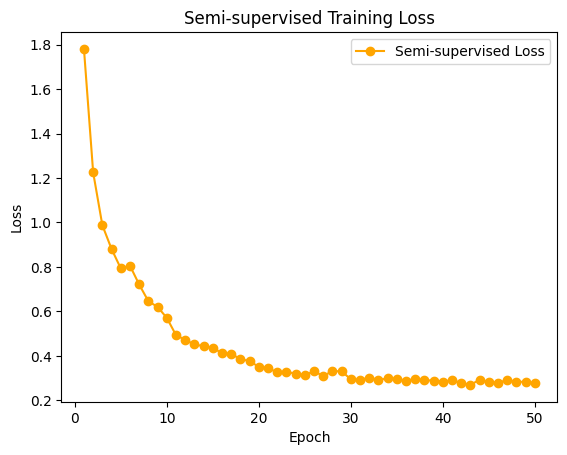

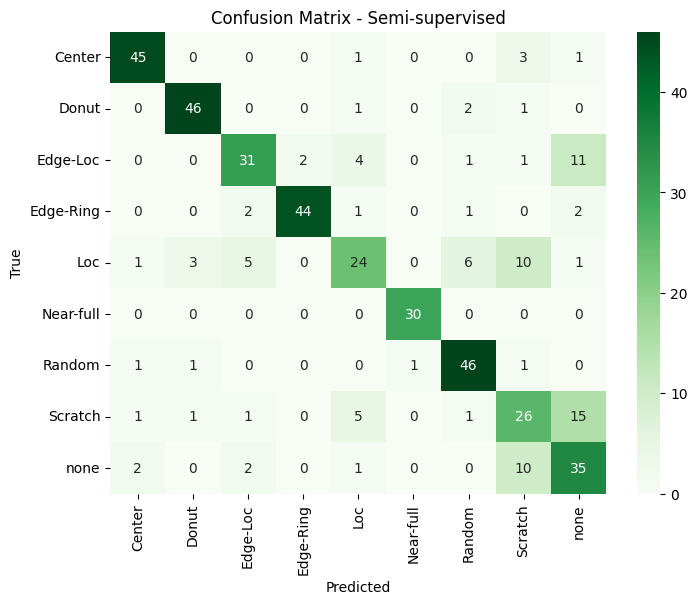

In [1]:
import os
import random
import math
import time
import cv2
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# 1. Environment setup and seed fixing
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

BATCH_SIZE = 32            # supervised batch size
MU = 7                     # unlabeled batch is BATCH_SIZE * MU
THRESHOLD = 0.95           # pseudo-label confidence threshold
T = 1.0                    # temperature
LAMBDA_U = 1.0             # unlabeled loss weight
NUM_CLASSES = 9
LR = 1e-3
EPOCHS = 50
TARGET_SHAPE = (26, 26)    # (height, width)

# 2. Wafer map preprocessing function
def process_wafer_map(wafer_map, target_size=TARGET_SHAPE):
    img = np.array(wafer_map, dtype=np.uint8)
    img_resized = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    color_map = {0: [0, 0, 0],
                 1: [0, 255, 0],
                 2: [255, 0, 0]}
    colored_img = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    for key, color in color_map.items():
        colored_img[img_resized == key] = color
    return colored_img.astype(np.float32) / 255.0

# 3. Data loading and splitting
print("Loading data")
data = pd.read_pickle('LSWMD.pkl')
print("Entire data shape:", data.shape)

# Select labeled data (where failureType list is not empty)
data_labelled = data[data['failureType'].map(lambda x: len(x) != 0)].copy()
print("Labeled data shape:", data_labelled.shape)

# Process failureType and trianTestLabel
data_labelled['failureType'] = data_labelled['failureType'].map(lambda x: str(x[0][0]))
data_labelled['trianTestLabel'] = data_labelled['trianTestLabel'].map(lambda x: x[0][0])
data_labelled.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
class_to_idx = {name: i for i, name in enumerate(classes)}
print("Class list:", classes)

# 80:20 split for each class
train_list = []
test_list = []
for cls in classes:
    df_cls = data_labelled[data_labelled['failureType'] == cls]
    df_train = df_cls.sample(frac=0.8, random_state=seed)
    df_test = df_cls.drop(df_train.index)
    train_list.append(df_train)
    test_list.append(df_test)
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Supervised experiment: Maximum of 100 training and 50 test samples per class
supervised_train_list = []
supervised_test_list = []
for cls in classes:
    df_cls_train = train_df[train_df['failureType'] == cls]
    n_train = min(len(df_cls_train), 100)
    df_sample_train = df_cls_train.sample(n=n_train, random_state=seed)
    supervised_train_list.append(df_sample_train)
    
    df_cls_test = test_df[test_df['failureType'] == cls]
    n_test = min(len(df_cls_test), 50)
    df_sample_test = df_cls_test.sample(n=n_test, random_state=seed)
    supervised_test_list.append(df_sample_test)
supervised_train_df = pd.concat(supervised_train_list).reset_index(drop=True)
supervised_test_df = pd.concat(supervised_test_list).reset_index(drop=True)
print("Supervised - Training data shape:", supervised_train_df.shape)
print("Supervised - Test data shape:", supervised_test_df.shape)

# Semi-supervised experiment:
# labeled: Use maximum of 100 per class
semi_sup_labeled_list = []
for cls in classes:
    df_cls = train_df[train_df['failureType'] == cls]
    n = min(len(df_cls), 100)
    df_sample = df_cls.sample(n=n, random_state=seed)
    semi_sup_labeled_list.append(df_sample)
semi_sup_labeled_df = pd.concat(semi_sup_labeled_list).reset_index(drop=True)
print("Semi-supervised - Labeled training data shape:", semi_sup_labeled_df.shape)

# - unlabeled: Select non-overlapping with labeled data (maximum 10,000)
semi_sup_unlabeled_df = train_df.loc[~train_df.index.isin(semi_sup_labeled_df.index)].copy()
if len(semi_sup_unlabeled_df) >= 10000:
    semi_sup_unlabeled_df = semi_sup_unlabeled_df.sample(n=10000, random_state=seed)
else:
    semi_sup_unlabeled_df = semi_sup_unlabeled_df.copy()
print("Semi-supervised - Unlabeled training data shape:", semi_sup_unlabeled_df.shape)

# Function to load image and label
def load_image_and_label(row):
    img = process_wafer_map(row['waferMap'], target_size=TARGET_SHAPE)
    label = class_to_idx.get(row['failureType'], 0)
    return img, label

def load_image(row):
    return process_wafer_map(row['waferMap'], target_size=TARGET_SHAPE)

# Generate supervised train/test data
sup_train_images, sup_train_labels = [], []
for idx, row in supervised_train_df.iterrows():
    img, label = load_image_and_label(row)
    sup_train_images.append(img)
    sup_train_labels.append(label)
sup_train_images = np.array(sup_train_images)
sup_train_labels = np.array(sup_train_labels)

sup_test_images, sup_test_labels = [], []
for idx, row in supervised_test_df.iterrows():
    img, label = load_image_and_label(row)
    sup_test_images.append(img)
    sup_test_labels.append(label)
sup_test_images = np.array(sup_test_images)
sup_test_labels = np.array(sup_test_labels)

# Semi-supervised labeled data
semi_sup_labeled_images, semi_sup_labeled_labels = [], []
for idx, row in semi_sup_labeled_df.iterrows():
    img, label = load_image_and_label(row)
    semi_sup_labeled_images.append(img)
    semi_sup_labeled_labels.append(label)
semi_sup_labeled_images = np.array(semi_sup_labeled_images)
semi_sup_labeled_labels = np.array(semi_sup_labeled_labels)

# Semi-supervised unlabeled data 
semi_sup_unlabeled_images = []
for idx, row in semi_sup_unlabeled_df.iterrows():
    img = load_image(row)
    semi_sup_unlabeled_images.append(img)
semi_sup_unlabeled_images = np.array(semi_sup_unlabeled_images)

print("sup_train_images shape:", sup_train_images.shape)
print("sup_test_images shape:", sup_test_images.shape)
print("semi_sup_labeled_images shape:", semi_sup_labeled_images.shape)
print("semi_sup_unlabeled_images shape:", semi_sup_unlabeled_images.shape)

# 4. Define PyTorch Datasets
class LabeledDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray((img*255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

class UnlabeledDataset(Dataset):
    def __init__(self, images, weak_transform=None, strong_transform=None):
        self.images = images
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray((img*255).astype(np.uint8))
        weak_img = self.weak_transform(img) if self.weak_transform else transforms.ToTensor()(img)
        strong_img = self.strong_transform(img) if self.strong_transform else transforms.ToTensor()(img)
        return weak_img, strong_img

class TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray((img*255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

class UnlabeledAEDataset(Dataset):
    def __init__(self, images):
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        # numpy (26,26,3) -> tensor (3,26,26)
        img_tensor = torch.tensor(img).permute(2, 0, 1).float()
        return img_tensor, img_tensor

# 5. Define Transforms 
weak_transform = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.ToTensor()
])

# 6. Define and train PyTorch Autoencoder (unlabeled data)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: (3,26,26) -> (64,7,7)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),   # (32,26,26)
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True), # (32,13,13)
            nn.Conv2d(32, 64, 3, padding=1),    # (64,13,13)
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True)  # (64,7,7)
        )
        # Decoder: (64,7,7) -> (3,26,26)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),  # (32,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2)      # (3,28,28)
        )
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        x_recon = F.interpolate(x_recon, size=TARGET_SHAPE, mode='nearest')
        return x_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
ae_dataset = UnlabeledAEDataset(semi_sup_unlabeled_images)
# Set num_workers of DataLoader to 0.
ae_loader = DataLoader(ae_dataset, batch_size=64, shuffle=True, num_workers=0)
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
ae_epochs = 15
criterion_ae = nn.MSELoss()

print("Starting Autoencoder training")
for epoch in range(ae_epochs):
    autoencoder.train()
    total_loss = 0
    for batch_in, batch_target in ae_loader:
        batch_in = batch_in.to(device)
        batch_target = batch_target.to(device)
        ae_optimizer.zero_grad()
        outputs = autoencoder(batch_in)
        loss = criterion_ae(outputs, batch_target)
        loss.backward()
        ae_optimizer.step()
        total_loss += loss.item() * batch_in.size(0)
    avg_loss = total_loss / len(ae_dataset)
    print(f"Autoencoder Epoch [{epoch+1}/{ae_epochs}], Loss: {avg_loss:.4f}")
print("Autoencoder training complete.")

class Random90Rotation(object):
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        return img.rotate(angle)

# 7. Define Autoencoder-based strong_transform
class AutoencoderTransform(object):
    def __init__(self, autoencoder, noise_std=0.05, device='cpu', black_thresh=0.1, green_delta=0.2):
        self.autoencoder = autoencoder
        self.noise_std = noise_std
        self.device = device
        self.black_thresh = black_thresh
        self.green_delta = green_delta
    def __call__(self, img):
        # PIL Image -> tensor (C,H,W) in [0,1]
        img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            latent = self.autoencoder.encoder(img_tensor)
            noise = torch.randn_like(latent) * self.noise_std
            latent_noisy = latent + noise
            recon = self.autoencoder.decoder(latent_noisy)
            recon = F.interpolate(recon, size=TARGET_SHAPE, mode='nearest')
        recon = recon.squeeze(0).cpu()
        # tensor (3,H,W) -> numpy (H,W,3)
        recon_np = recon.permute(1, 2, 0).numpy()
        # Postprocessing: Apply conditions for each pixel
        h, w, _ = recon_np.shape
        out = np.empty((h, w, 3), dtype=np.float32)
        for i in range(h):
            for j in range(w):
                pixel = recon_np[i, j, :]
                if np.mean(pixel) < self.black_thresh:
                    out[i, j, :] = [0, 0, 0]
                elif (pixel[1] >= pixel[0] and pixel[1] >= pixel[2] and 
                      ((pixel[1]-pixel[0]) >= self.green_delta or (pixel[1]-pixel[2]) >= self.green_delta)):
                    out[i, j, :] = [0, 1, 0]
                else:
                    out[i, j, :] = [1, 0, 0]
        out_img = Image.fromarray((out * 255).astype(np.uint8))
        return transforms.ToTensor()(out_img)

strong_transform = transforms.Compose([
    AutoencoderTransform(autoencoder, noise_std=0.05, device=device, black_thresh=0.1, green_delta=0.2),
    transforms.ToPILImage(),
    Random90Rotation(),
    transforms.ToTensor()
])

# Define functions for data visualization
def show_sample_images_labeled(images, labels, classes, num_samples=1):
    plt.figure(figsize=(3 * len(classes), 3))
    for i, cls in enumerate(classes):
        cls_idxs = np.where(labels == class_to_idx[cls])[0]
        if len(cls_idxs) == 0:
            continue
        sample_idx = np.random.choice(cls_idxs)
        plt.subplot(1, len(classes), i+1)
        plt.imshow(images[sample_idx])
        plt.title(cls)
        plt.axis('off')
    plt.suptitle("Original Data: Sample images for each class")
    plt.tight_layout()
    plt.show()

def show_augmented_images(synthetic_images, synthetic_labels, classes, samples_per_class=2):
    aug_classes = [cls for cls in classes if cls != "none"]
    n_cols = len(aug_classes)
    plt.figure(figsize=(3 * n_cols, 6))
    for i, cls in enumerate(aug_classes):
        cls_idx = class_to_idx[cls]
        idxs = np.where(synthetic_labels == cls_idx)[0]
        if len(idxs) > 0:
            if len(idxs) >= samples_per_class:
                sample_idxs = np.random.choice(idxs, size=samples_per_class, replace=False)
            else:
                sample_idxs = [idxs[0]] * samples_per_class
            # First row
            plt.subplot(2, n_cols, i+1)
            plt.imshow(synthetic_images[sample_idxs[0]])
            plt.title(cls)
            plt.axis('off')
            # Second row
            plt.subplot(2, n_cols, n_cols + i + 1)
            plt.imshow(synthetic_images[sample_idxs[1]])
            plt.axis('off')
    plt.suptitle("Augmented Data: 2 sample images per class", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_before_after_augmentation(images, labels, classes, transform):
    aug_classes = [cls for cls in classes if cls != "none"]
    n_cols = len(aug_classes)
    plt.figure(figsize=(3 * n_cols, 6))
    for i, cls in enumerate(aug_classes):
        cls_idx = class_to_idx[cls]
        idxs = np.where(labels == cls_idx)[0]
        if len(idxs) == 0:
            continue
        sample_idx = np.random.choice(idxs)
        orig_img = images[sample_idx]
        pil_img = Image.fromarray((orig_img * 255).astype(np.uint8))
        aug_img_tensor = transform(pil_img)
        aug_img_np = np.transpose(aug_img_tensor.numpy(), (1, 2, 0))
        # Original image
        plt.subplot(2, n_cols, i+1)
        plt.imshow(orig_img)
        plt.title(f"{cls}\nOriginal")
        plt.axis('off')
        # Augmented image
        plt.subplot(2, n_cols, n_cols + i + 1)
        plt.imshow(aug_img_np)
        plt.title(f"{cls}\nAugmented")
        plt.axis('off')
    plt.suptitle("Original vs Augmented (per class)", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_autoencoder_comparison_pytorch(images, labels, classes, transform):
    aug_classes = [cls for cls in classes if cls != "none"]
    n_cols = len(aug_classes)
    plt.figure(figsize=(3 * n_cols, 6))
    for i, cls in enumerate(aug_classes):
        cls_idx = class_to_idx[cls]
        idxs = np.where(labels == cls_idx)[0]
        if len(idxs) == 0:
            continue
        sample_idx = np.random.choice(idxs)
        orig_img = images[sample_idx]  # (26,26,3)
        pil_img = Image.fromarray((orig_img * 255).astype(np.uint8))
        aug_img_tensor = transform(pil_img)
        aug_img_np = np.transpose(aug_img_tensor.numpy(), (1, 2, 0))
        # Display original image
        plt.subplot(2, n_cols, i+1)
        plt.imshow(orig_img)
        plt.title(f"{cls}\nOriginal")
        plt.axis('off')
        # Display augmented image
        plt.subplot(2, n_cols, n_cols+i+1)
        plt.imshow(aug_img_np)
        plt.title(f"{cls}\nAugmented")
        plt.axis('off')
    plt.suptitle("PyTorch Autoencoder: Comparison before and after augmentation (per class)", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_sample_images_unlabeled(images, num_samples=2):
    if len(images) == 0:
        print("No unlabeled samples available.")
        return
    sample_indices = random.sample(range(len(images)), min(num_samples, len(images)))
    plt.figure(figsize=(3 * num_samples, 3))
    for j, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, j + 1)
        plt.imshow(images[idx])
        plt.title("Unlabeled")
        plt.axis('off')
    plt.suptitle("Unlabeled Data Samples")
    plt.show()

def show_unlabeled_augmentation_comparison(images, weak_transform, strong_transform, num_samples=5):
    """
    Compares the original, weak augmentation, and strong augmentation results side-by-side for random unlabeled samples.
    """
    plt.figure(figsize=(12, 3 * num_samples))
    for i in range(num_samples):
        idx = random.choice(range(len(images)))
        orig = images[idx]
        pil_img = Image.fromarray((orig * 255).astype(np.uint8))
        weak_img = weak_transform(pil_img)
        strong_img = strong_transform(pil_img)
        weak_img_np = np.transpose(weak_img.numpy(), (1, 2, 0))
        strong_img_np = np.transpose(strong_img.numpy(), (1, 2, 0))
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(orig)
        plt.title("Original")
        plt.axis('off')
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(weak_img_np)
        plt.title("Weak Aug")
        plt.axis('off')
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(strong_img_np)
        plt.title("Strong Aug")
        plt.axis('off')
    plt.suptitle("Unlabeled Data Augmentation Comparison (Original vs Weak vs Strong)")
    plt.tight_layout()
    plt.show()

# 7. Visualization before training
print("\n[Original Data] Sample image for each class (1 each)")
show_sample_images_labeled(sup_train_images, sup_train_labels, classes, num_samples=1)

print("\n[Unlabeled Data] Displaying 2 samples")
show_sample_images_unlabeled(semi_sup_unlabeled_images, num_samples=2)

# Unlabeled data augmentation comparison: Original, weak, strong
print("\n[Unlabeled Augmentation Comparison] Original vs Weak vs Strong")
show_unlabeled_augmentation_comparison(semi_sup_unlabeled_images, weak_transform, strong_transform, num_samples=5)

# Visualization of augmented data (based on supervised): 2 samples per class
synthetic_images = []
synthetic_labels = []
for img, label in zip(sup_train_images, sup_train_labels):
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    aug_img = strong_transform(pil_img)
    aug_img_np = np.transpose(aug_img.numpy(), (1, 2, 0))
    synthetic_images.append(aug_img_np)
    synthetic_labels.append(label)
synthetic_images = np.array(synthetic_images)
synthetic_labels = np.array(synthetic_labels)

print("\n[Augmented Data] Augmented sample images for each class (2 each)")
show_augmented_images(synthetic_images, synthetic_labels, classes, samples_per_class=2)

print("\n[Original vs Augmented] Comparison per class (supervised)")
show_before_after_augmentation(sup_train_images, sup_train_labels, classes, strong_transform)

print("\n[Autoencoder Augmentation Comparison] per class (supervised)")
show_autoencoder_comparison_pytorch(sup_train_images, sup_train_labels, classes, strong_transform)

# 8. Create DataLoaders 
sup_train_dataset = LabeledDataset(sup_train_images, sup_train_labels, transform=weak_transform)
sup_test_dataset = TestDataset(sup_test_images, sup_test_labels, transform=test_transform)
sup_train_loader = DataLoader(sup_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
sup_test_loader = DataLoader(sup_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

semi_sup_labeled_dataset = LabeledDataset(semi_sup_labeled_images, semi_sup_labeled_labels, transform=weak_transform)
semi_sup_unlabeled_dataset = UnlabeledDataset(semi_sup_unlabeled_images, weak_transform=weak_transform, strong_transform=strong_transform)
semi_sup_labeled_loader = DataLoader(semi_sup_labeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
semi_sup_unlabeled_loader = DataLoader(semi_sup_unlabeled_dataset, batch_size=BATCH_SIZE * MU, shuffle=True, num_workers=0, drop_last=True)

# 9. Define classification model CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 10. Define training and evaluation functions
def train_supervised(model, loader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    num_iter = len(loader)
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / num_iter

def train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    unlabeled_used_total = 0
    unlabeled_total = 0
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    num_iter = min(len(labeled_loader), len(unlabeled_loader))
    for _ in range(num_iter):
        try:
            inputs_x, targets_x = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            inputs_x, targets_x = next(labeled_iter)
        try:
            inputs_u_w, inputs_u_s = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            inputs_u_w, inputs_u_s = next(unlabeled_iter)
        inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
        inputs_u_w = inputs_u_w.to(device)
        inputs_u_s = inputs_u_s.to(device)
        
        # Labeled loss
        logits_x = model(inputs_x)
        loss_x = criterion(logits_x, targets_x)
        
        # Unlabeled: Generate pseudo-label (using weak augmentation)
        with torch.no_grad():
            logits_u_w = model(inputs_u_w)
            pseudo_label = torch.softmax(logits_u_w / T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = (max_probs >= THRESHOLD).float()
        unlabeled_used_total += mask.sum().item()
        unlabeled_total += mask.numel()
        
        logits_u_s = model(inputs_u_s)
        loss_u = (criterion(logits_u_s, targets_u) * mask).mean()
        
        loss = loss_x + LAMBDA_U * loss_u
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_iter
    usage_ratio = unlabeled_used_total / unlabeled_total if unlabeled_total > 0 else 0
    print(f"Epoch {epoch}: Unlabeled usage ratio = {usage_ratio:.3f} ({unlabeled_used_total}/{unlabeled_total})")
    return avg_loss

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    acc = 100.0 * correct / total
    report = classification_report(all_targets, all_preds, target_names=classes)
    return acc, report, all_preds, all_targets

criterion = nn.CrossEntropyLoss(reduction='mean')

# 11. Run the entire experiments: Supervised vs Semi-supervised 
if __name__ == '__main__':
    # Supervised Experiment 
    print("\n=== Supervised Experiment ===")
    model_sup = SimpleCNN(num_classes=NUM_CLASSES).to(device)
    optimizer_sup = optim.Adam(model_sup.parameters(), lr=LR)
    scheduler_sup = torch.optim.lr_scheduler.StepLR(optimizer_sup, step_size=10, gamma=0.5)
    supervised_losses = []
    for epoch in range(1, EPOCHS + 1):
        loss_sup = train_supervised(model_sup, sup_train_loader, optimizer_sup, epoch, device)
        supervised_losses.append(loss_sup)
        scheduler_sup.step()
        print(f"[Supervised] Epoch {epoch} Loss: {loss_sup:.4f}")
    acc_sup, report_sup, preds_sup, targets_sup = evaluate(model_sup, sup_test_loader, device)
    print("\n[Supervised Experiment Results]")
    print(f"Test Accuracy: {acc_sup:.2f}%")
    print(report_sup)
    plt.figure()
    plt.plot(range(1, EPOCHS+1), supervised_losses, marker='o', label='Supervised Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Supervised Training Loss")
    plt.legend()
    plt.show()
    cm_sup = confusion_matrix(targets_sup, preds_sup)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_sup, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Supervised")
    plt.show()
    
    # Semi-supervised Experiment (FixMatch)
    print("\n=== Semi-supervised Experiment ===")
    model_semi = SimpleCNN(num_classes=NUM_CLASSES).to(device)
    optimizer_semi = optim.Adam(model_semi.parameters(), lr=LR)
    scheduler_semi = torch.optim.lr_scheduler.StepLR(optimizer_semi, step_size=10, gamma=0.5)
    semi_losses = []
    for epoch in range(1, EPOCHS + 1):
        loss_semi = train_fixmatch(model_semi, semi_sup_labeled_loader, semi_sup_unlabeled_loader, optimizer_semi, epoch, device)
        semi_losses.append(loss_semi)
        scheduler_semi.step()
        print(f"[Semi-supervised] Epoch {epoch} Loss: {loss_semi:.4f}")
    acc_semi, report_semi, preds_semi, targets_semi = evaluate(model_semi, sup_test_loader, device)
    print("\n[Semi-supervised Experiment Results]")
    print(f"Test Accuracy: {acc_semi:.2f}%")
    print(report_semi)
    plt.figure()
    plt.plot(range(1, EPOCHS+1), semi_losses, marker='o', color='orange', label='Semi-supervised Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Semi-supervised Training Loss")
    plt.legend()
    plt.show()
    cm_semi = confusion_matrix(targets_semi, preds_semi)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_semi, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Greens")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Semi-supervised")
    plt.show()
